# LIBRARIES

In [1]:
import numpy as np

import random
from joblib import Parallel, delayed

random.seed(42)  
np.random.seed(42)  


In [2]:
from tradeClass import *
from networkLogic import *

# Introduction

This study seeks to examine bilateral trade interdependencies within the global oil and gas industries through a Pairwise Mutual Information Weighted Graph (PMIWG). By estimating mutual information from non-parametric distributions of bidirectional trade volumes, this approach quantifies complex, non-linear trade interdependencies without implying causality. The analysis demonstrates that mutual information effectively captures significant economic relationships where strenght of relationships are correlated with factors such as geographical proximity, trade policies, and bilateral agreements. Furthermore, the method successfully segments the global trade network into distinct economic blocs, highlighting its capability to capture essential trade dynamics.

The central research question posits that that bilateral trade relationships retain a degree of economic independence due to specific trade policies, tariffs, and bilateral agreements unique to each pair of trading nation. The central hypothesis of this paper suggests that mutual information can effectively capture the strength of these interdependencies. 

The validation of this hypothesis involves several specific sub-hypotheses:

a) High mutual information indicates Strong Interdependence: This study tests the assertion that high mutual information between country pairs correlates with significant interdependencies, evidenced by factors such as geographical proximity, mutually beneficial trade agreements, or integrated supply chains. This suggests that mutual information, as derived from empirical trade volume data, effectively captures these interdependencies.

b) Economic Segregation within the PMIWG: The research evaluates whether communities identified within the PMIWG are meaningfully segregated into economic blocs or strategic groupings, indicating that pairwise mutual information is capable of meaningfully representing global trade dynamics through direct bilateral relationships, even without accounting for higher-order dependencies.

To achieve these objectives, non-parametric methods will be used to estimate the probability density functions (PDFs) and subsequently calculate mutual information between trade volume distributions of various country pairs. 

The methods amd theory are largely drawn from online resources and textbooks, in particular:
- All of Nonparametric Statistics - Larry Wasserman
- Elements of Information Theory - Thomas M. Cover and Joy A. Thomas

## DATA LOADING

This study utilises monthly import data for mineral fuels from the UN Comtrade Database, covering the period from 2005 to 2023. For each pair, the study models the probability density function (PDF) of exports from one country to another and estimates the joint PDF for bilateral trade dynamics. 

In [3]:
file_path = r'C:\Users\mcdou\OneDrive - University College London\Desktop\data science\Data-Science\Data_\23_03_Oil.csv'

data = pd.read_csv(file_path)


In [4]:
data = data[data['Value (SUM)'] > 0]
data = data[data['Year'] >= 2005].reset_index(drop=True)
data


Export_country   Import_country  Month  Year  Value (SUM)
0              Afghanistan          Andorra      1  2022     7515.075
1                  Belgium          Andorra      1  2022      999.849
2                   France          Andorra      1  2022  5029411.258
3                  Germany          Andorra      1  2022     4755.633
4                   Greece          Andorra      1  2022      183.295
...                    ...              ...    ...   ...          ...
728046               Italy     Burkina Faso     12  2005    12507.736
728047            Suriname            Italy     12  2005  6094276.499
728048  Bosnia Herzegovina          Türkiye     12  2005     8908.000
728049  Bosnia Herzegovina  North Macedonia     12  2005   123703.590
728050               Yemen            Spain     12  2005  1705446.138

[728051 rows x 5 columns]

In [5]:
data.isnull().sum()

Export_country    0
Import_country    0
Month             0
Year              0
Value (SUM)       0
dtype: int64

In [6]:
data.describe()

Month           Year   Value (SUM)
count  728051.000000  728051.000000  7.280510e+05
mean        6.503756    2016.120295  5.352635e+07
std         3.443624       4.598725  2.581349e+09
min         1.000000    2005.000000  2.000000e-03
25%         4.000000    2013.000000  2.079829e+04
50%         7.000000    2017.000000  2.767000e+05
75%         9.000000    2020.000000  9.744639e+06
max        12.000000    2023.000000  1.766962e+12

## Bidirectional Pairs

Accurate joint PDF estimation requires equal numbers of observations for exports in both directions, which can be challenging when one country exports significantly more than it imports, a typical scenario in import-heavy relationships. To address these discrepancies, imputing zero values for months with unilateral trade could be considered, although this may skew the distribution estimation. Truncating the longer sequence to match the shorter one is another option, but it can lead to substantial data loss in cases of extreme asymmetry. Therefore, the analysis is refined to focus on country pairs with at least 100 mutual trade transactions over the 216-month period.

In [7]:
interaction_counts = data.groupby(['Export_country', 'Import_country']).size().reset_index(name='Intractions')

in0teraction_counts = interaction_counts[interaction_counts['Intractions'] >= 100]

bidirectional_trades = []

for index, row in interaction_counts.iterrows():
    export_country = row['Export_country']
    import_country = row['Import_country']
    
    reverse_pair = interaction_counts[(interaction_counts['Export_country'] == import_country) & 
                                      (interaction_counts['Import_country'] == export_country)]
    
    if not reverse_pair.empty:
        reverse_count = reverse_pair['Intractions'].values[0]
        bidirectional_trades.append({
            "Export_country": export_country,
            "Import_country": import_country,
            "Export_to_Import_Count": row['Intractions'],
            "Import_to_Export_Count": reverse_count
        })

bidirectional_trades_df = pd.DataFrame(bidirectional_trades)

bidirectional_trades_df = bidirectional_trades_df.drop_duplicates(subset=['Export_country', 'Import_country'])

unique_country_pairs = list(zip(bidirectional_trades_df['Export_country'], bidirectional_trades_df['Import_country']))

country_list = list(set([country for pair in unique_country_pairs for country in pair]))

The logarithm of the trade volume is applied in the analysis to reduce the impact of extreme outliers

In [8]:
df = pd.DataFrame(data)
log_df = df.copy()
log_df['Value (SUM)'] = np.log1p(df['Value (SUM)'])
log_df['Date'] = pd.to_datetime(log_df[['Year', 'Month']].assign(DAY=1))
log_df.set_index('Date', inplace=True)

print(log_df.head())

           Export_country Import_country  Month  Year  Value (SUM)
Date                                                              
2022-01-01    Afghanistan        Andorra      1  2022     8.924799
2022-01-01        Belgium        Andorra      1  2022     6.908604
2022-01-01         France        Andorra      1  2022    15.430814
2022-01-01        Germany        Andorra      1  2022     8.467295
2022-01-01         Greece        Andorra      1  2022     5.216538


# Case Study

## Initialisation 

The class initialises the information for the two countries in question, which for this case is Argentina and Brazil. It creates a timeseries of trade volume from Argentina to Brazil and from Brazil to Argentina. 

We first start by ensuring that the lengths of both data is the same and preparing the data sets. This is done with the initialization of the class with the extract_trade_volumes method. Trade volume will be treated as a random variable independent of time, focusing on
the distribution of trade values themselves, regardless of their temporal occurrence.

In [9]:
case_study = TradeAnalysis(log_df, 'Argentina', 'Brazil')

In [10]:
len(case_study.data_x_to_y)

168

In [11]:
len(case_study.data_y_to_x)

168

## PDF Estimation 

In order to estimate the PDF for mutual information calculations we need to  estimate the probability distribution for the two trade volumnes. This is done discretely using a histogram and continuously using a kernel density estimation. These methods require precise parameter selection. Specifically, the bin size for histograms and the bandwidth for KDE, as these greatly affect the entropy estimates of the distribution.


Optimal bin sizes for histograms and bandwidths for KDE are identified using maximum likelihood estimation (MLE). However, MLE often leads to overfitting by favouring smaller parameter values. To mitigate this, a 10-fold cross-validation with a 70-30 split is employed, using ShuffleSplit to ensure model generalisation, and the median over folds is chosen as the optimal parameter. The median is used as the central tendency measure over the mean, as when there are very few data points, the median is a more robust estimate that's less sensitive to outliers or skewed distributions of selected bandwidths/bin size. The same method is employed for kernel.

The best histogram bin size found with this method for the import data of Brazil and Argentina is 8 and 18 respectively

In [12]:
case_study.optimal_bins_x_to_y, case_study.optimal_bins_y_to_x

(8, 18)

likewise for bandwidth is 0.31 and 0.18 respectively 

In [13]:
case_study.best_bandwidth_x_to_y, case_study.best_bandwidth_y_to_x 

(0.31724137931034485, 0.1806896551724138)

The optimal bandwidth and bin size derived from cross-validation MLE plotted seem to capture the data well without overfitting, resulting in bimodal distributions. KDE curves also provide a good fit to the histograms, smoothly interpolating between points and revealing the underlying distribution shape. The variation in distributions derived even from a single pair, validate the non-parametric approach.

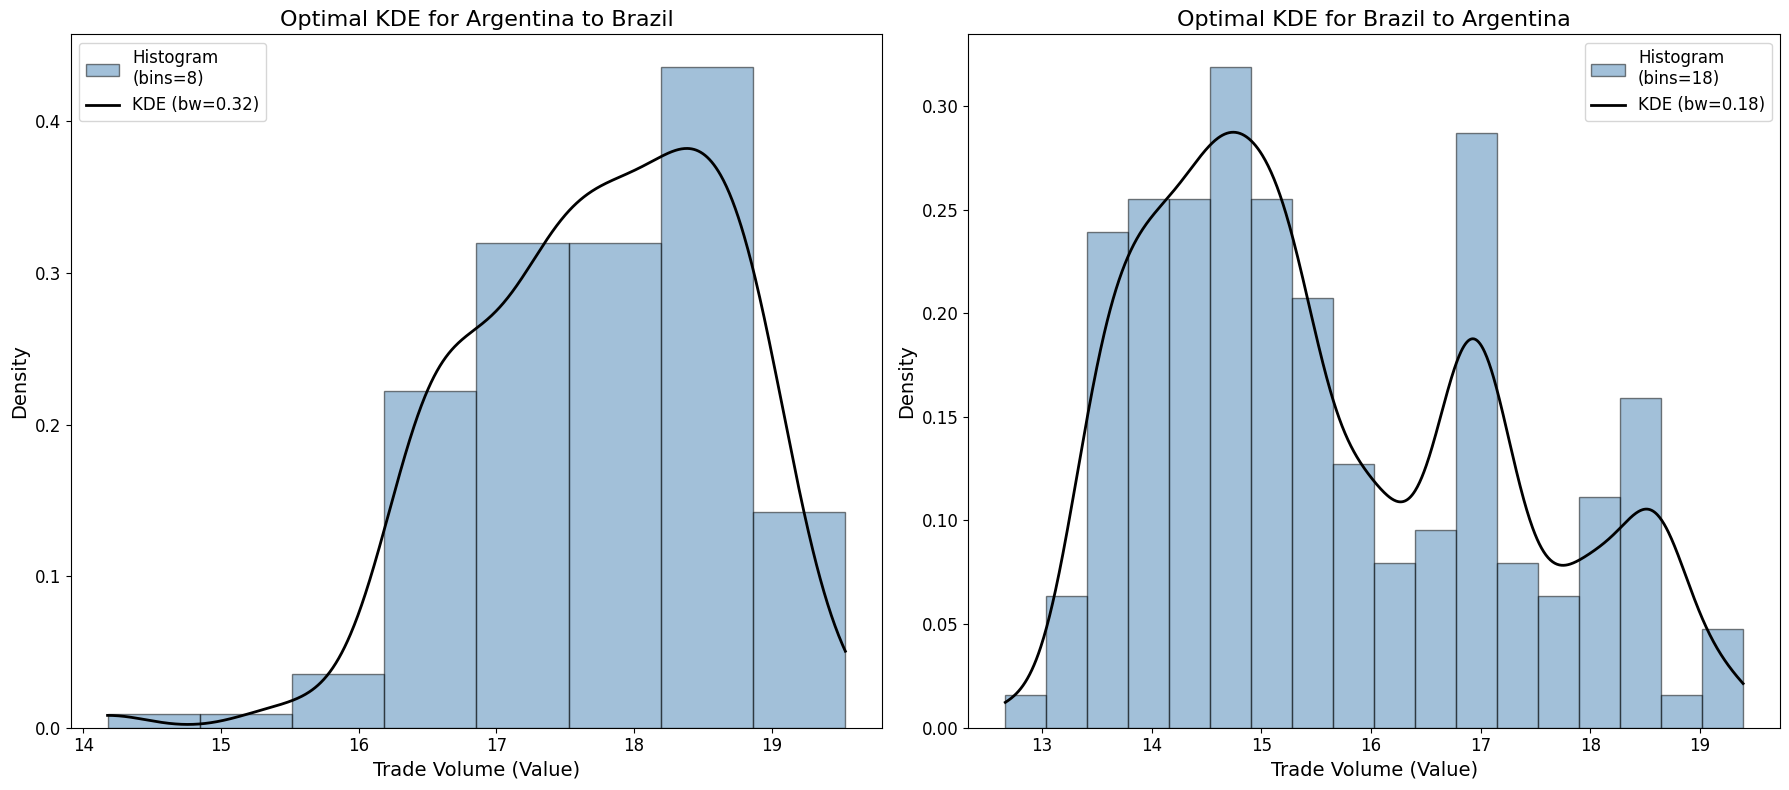

In [14]:
case_study.plot_kde_hist()

The derived estimates demonstrate a strong goodness-of-fit, as shown in the P-P plot comparing the MLE optimal bandwidth KDE against the empirical CDF. These plots reveal that the KDE closely mirrors both the central tendency and the tails of the empirical distribution, indicating a good fit with minimal systematic deviation

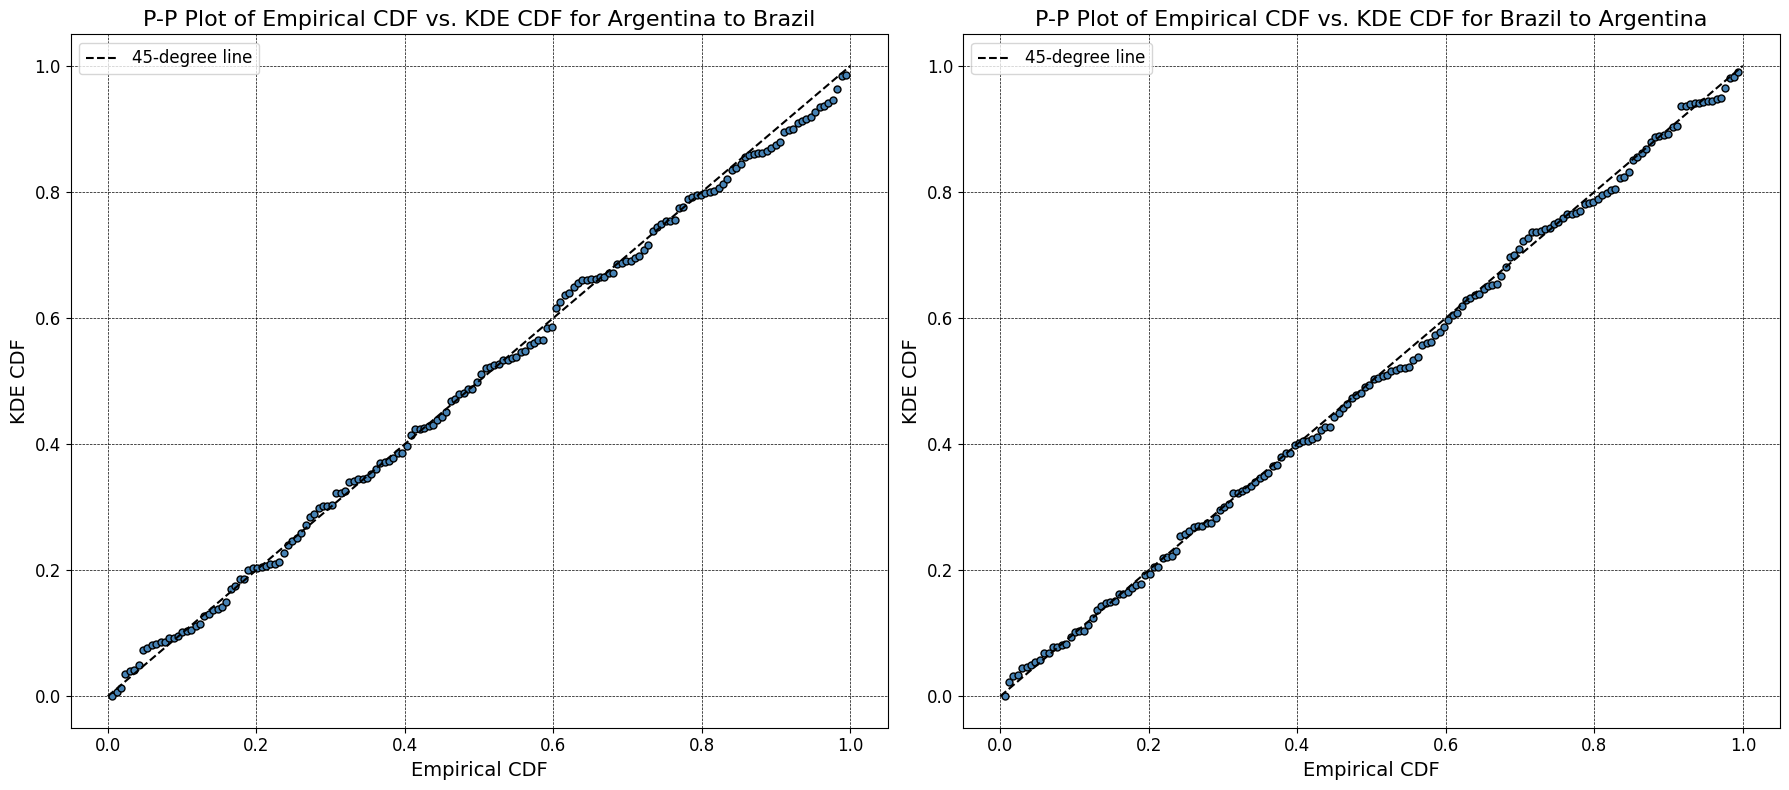

In [15]:
case_study.plot_pp()

# Joint Estimation 

After successfully fitting and verifying the marginal PDFs, the joint PDF is derived by extending the existing methodology to a multidimensional analysis. The visualisations, featuring multiple peaks or clusters of dark blue, indicate that certain pairs of trade volumes occur more frequently than others. Suggesting that the dependency is not well defined and clearly non-linear

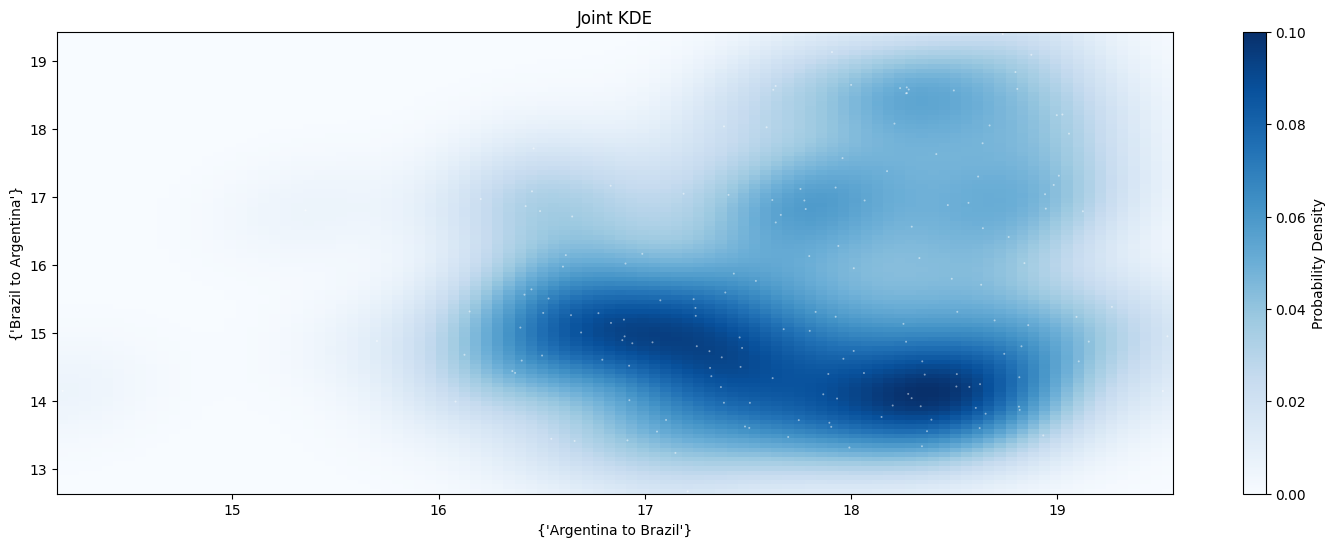

In [16]:
case_study.plot_joint_kde()

# Mutual Information 

Mutual information quantifies the overlap in information between two discrete random variables, serving as a measure of non-parametric dependence. In this context, as the log volume random variables are continuous, they are discretized by segmenting into intervals to facilitate the computation of mutual information between two countries, given by:


$I(X_i; X_j) = H(X_i) + H(X_j) - H(X_i, X_j)$


Here, $H(X_i)$ and $H(X_j)$ denote the Shannon entropy of $X_i$ and $X_j$, respectively, reflecting the amount of uncertainty or information contained within each variable. The joint entropy $H(X_i, X_j)$ captures the uncertainty associated with both variables when considered simultaneously. These entropy values are estimated from the data using the histogram approximations:

\begin{equation}
H(X_i) = -\sum p(x_i) \log p(x_i),
\end{equation}

where $p(x_i)$ represents the probability mass function of $X_i$, estimated from the data. 

For linearly dependent variables, mutual information can be expressed in terms of Pearson's correlation coefficient $\rho$, defined by:
\begin{equation}
I_{\text{linear}}(X_i; X_j) = -\frac{1}{2} \log(1 - \rho^2).
\end{equation}


These results suggets that Argentina's exports to Brazil are less informative than Brazils exports to Argentina. 

In [17]:
case_study.shannon_entropy_joint

3.855414970438292

In [18]:
case_study.shannon_entropy_x_to_y

2.419390117958166

In [19]:
case_study.shannon_entropy_y_to_x

3.8413591129435707

The value for linear mutual information suggests a very low level of interdependency where as the non-linear measure suggests instead that there is a strong relationship between their trade volumes. 

In [20]:
case_study.mutual_info

2.4053342604634445

In [21]:
case_study.linear_mi

0.015988224360478486

## Running class on full data set

In [ ]:
failed_pairs = []

def analyze_pair(pair):
    try:
        analysis = TradeAnalysis(log_df, pair[0], pair[1])
        return {
            'Export_country': pair[0],
            'Import_country': pair[1],
            'Pearson_Correlation': analysis.pearson_corr,
            'Mutual_Information': analysis.mutual_info,
            'Linear_Mutual_Information': analysis.linear_mi,
        }
    except Exception as e:
        failed_pairs.append({'pair': pair, 'error': str(e)})
        return None 

results = Parallel(n_jobs=-1)(delayed(analyze_pair)(pair) for pair in tqdm(unique_country_pairs, desc="Analyzing pairs"))

results_df = pd.DataFrame([result for result in results if result is not None])
results_df.to_csv("processed_results.csv", index=False)

failed_pairs_df = pd.DataFrame(failed_pairs)
if not failed_pairs_df.empty:
    print("Failed pairs and their errors:")
    print(failed_pairs_df)


## Dependency Plots

The mutual information distribution plot shows a positive skew, such that instances of high mutual information are less common than pairs with low mutual information.

Text(0.5, 1.0, 'Mutual Information Distribution')

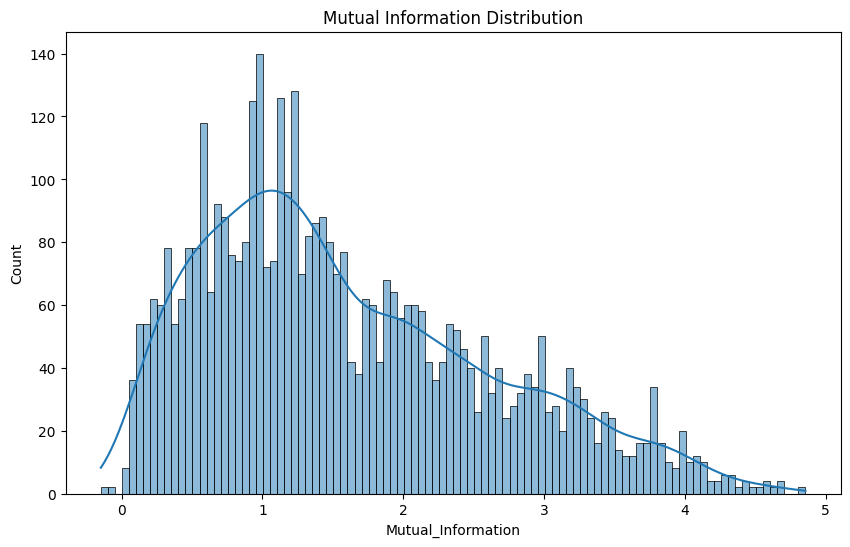

In [23]:
plt.figure(figsize=(10, 6))
sns.histplot(results_df['Mutual_Information'], bins=100, kde=True)
plt.title('Mutual Information Distribution')

# Network 

An undirected weighted graph is constructed using mutual information and its linear approximation as dependency measures, with nodes representing countries engaged in significant bilateral trade. The mutual information values, derived from empirical histograms of trade volume distributions, indicate how one country's trade to the other country informs about the trade in the other direction, with higher weights suggesting stronger and more predictable trade relationships. Key concepts employed to analyze the structural properties and dynamics of the network include and weight matrices, degree distributions, and centrality measures.

In [24]:
avg_balance_df = getAverageTradeBalance(data, country_list)

In [25]:
G_pearson = nx.Graph()
G_mi = nx.Graph()

for _, row in results_df.iterrows():
    G_pearson.add_edge(row['Export_country'], row['Import_country'], weight=row['Linear_Mutual_Information'])
    G_mi.add_edge(row['Export_country'], row['Import_country'], weight=row['Mutual_Information'])

for _, row in avg_balance_df.iterrows():
    if G_mi.has_node(row['Country']):
        G_mi.nodes[row['Country']]['export_value'] = row['Trade_Balance']

pearson_metrics_df = compute_metrics(G_pearson)
mi_metrics_df = compute_metrics(G_mi)

In [26]:
mi_metrics_df

Weighted_Degree_Centrality  Unweighted_Degree_Centrality  \
Albania                    10.093978                             9   
Bulgaria                   83.798066                            45   
France                    176.924329                           102   
Greece                    103.482517                            63   
Italy                     165.763849                            80   
...                              ...                           ...   
Eswatini                    5.186359                             2   
Grenada                     1.869466                             1   
Lesotho                     2.143252                             1   
Malawi                      6.108688                             5   
Maldives                    1.418296                             1   

          Avg_Weight_Centrality  Weighted_Eigenvector_Centrality  \
Albania                1.121553                         0.012716   
Bulgaria               1.862179                         0.109194   
France                 1.734552                         0.173073   
Greece                 1.642580                         0.132101   
Italy                  2.072048                         0.191392   
...                         ...                              ...   
Eswatini               2.593180                         0.005193   
Grenada                1.869466                         0.000528   
Lesotho                2.143252                         0.002571   
Malawi                 1.221738                         0.002039   
Maldives               1.418296                         0.000858   

          Betweenness_Centrality_Unweighted  Closeness_Centrality_Unweighted  
Albania                            0.000044                         0.472669  
Bulgaria                           0.002983                         0.576471  
France                             0.079357                         0.761658  
Greece                             0.005397                         0.622881  
Italy                              0.015222                         0.677419  
...                                     ...                              ...  
Eswatini                           0.000000                         0.398374  
Grenada                            0.000000                         0.342657  
Lesotho                            0.000000                         0.397297  
Malawi                             0.000032                         0.401639  
Maldives                           0.000000                         0.388889  

[148 rows x 6 columns]

## Network Plot

In these visualizations, larger nodes represent countries with higher total trade volumes,
indicating significant global import and export activity. Node colors, which show eigenvector centrality, vary to highlight the differing levels of influence of countries within the trade
networks. When comparing the two networks, it becomes evident that mutual information
captures complex trade relationships more effectively. The contrast in eigenvector centrality
across the two graphs emphasizes the superior ability of non-parametric measures to delineate complex interactions. Conversely, linear dependency measures tend to under-emphasize
many relationships, as evident from fainter connections between countries

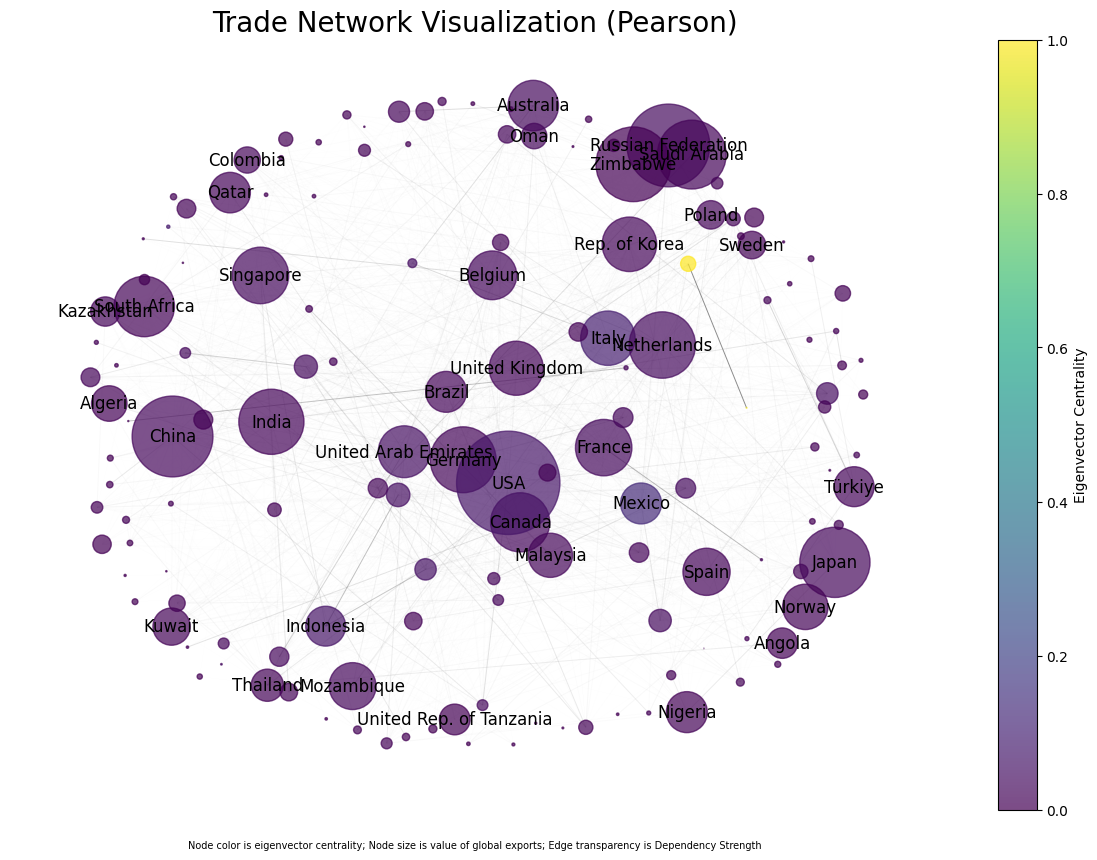

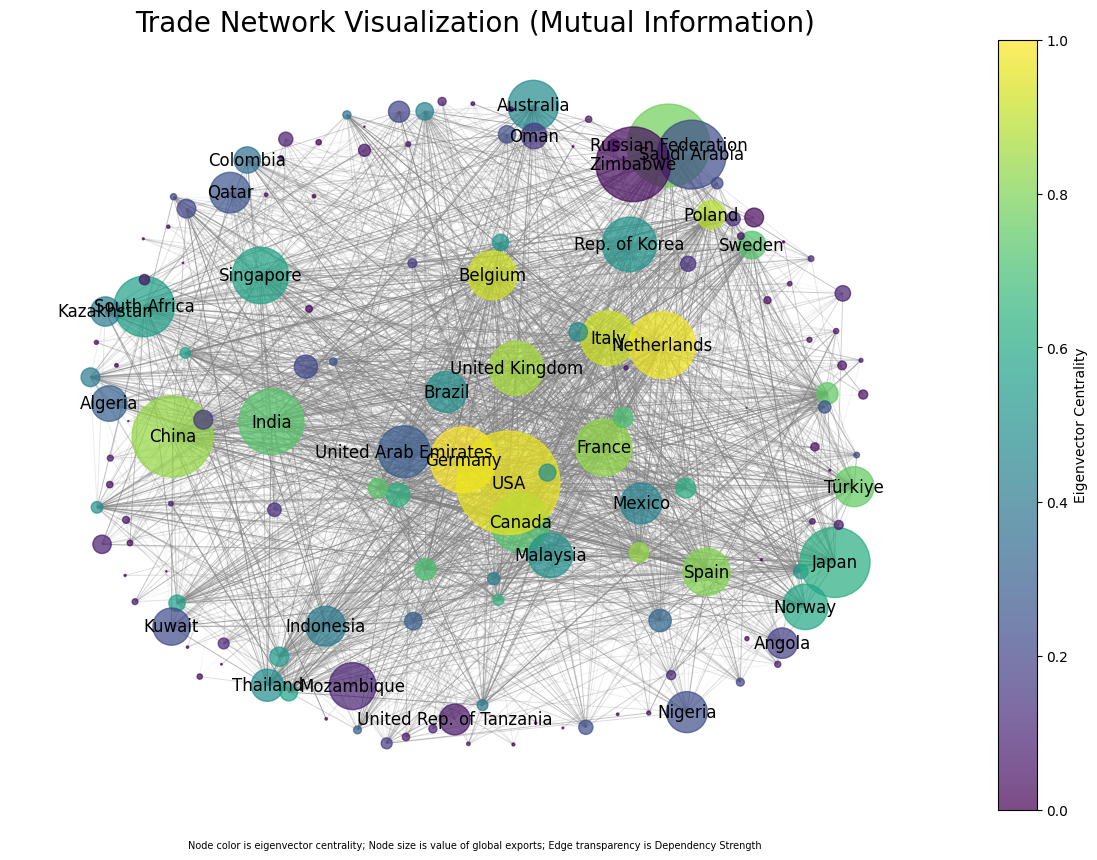

In [27]:

fixed_positions = nx.spring_layout(G_pearson, k = 0.9, seed=40)

visualize_full_network(G_pearson, avg_balance_df, fixed_positions, 'Trade Network Visualization (Pearson)', 'pearson_trade_network.png')
visualize_full_network(G_mi, avg_balance_df, fixed_positions, 'Trade Network Visualization (Mutual Information)', 'mutual_info_trade_network.png')


## Dependency Inspection

To explore the practical implications of the pairwise
mutual information approach, an in-depth analysis of the highest-ranking pairs will be conducted. This examination aims to determine whether the mutual information accurately
captured meaningful interdependencies, that are grounded in economic reasoning.

### Highest Mutual Information Pairs 

As the data we are using reflect both upstream and downstream products, it is possible that strong interdependencies would involve some kind of integrated supply chain.  In this way, that highest pairs are economically justified. The prominence of Italy in the higher correlation pairs could also be explained by vertically integrated trade agreement, as partners are nearby and members of the European free trade area. In the case of Italy, a large proportion of the companies refinery capacity and trade is conducted by the Italian supermajors like Eni S.p.A and one can imagine cross border value chains that span the partner countries of Romania, Luxembourg and Austria. 

Interestingly, Luxembourg and Italy, the pair with the highest mutual information, have a very low Pearson correlation and linear mutual information, potentially highlighting a strong, non-linear interrelation.

Lithuania and Poland having high levels of mutual information is unsurprising, as both are neighbours and EU members. It is possible that the countries have legacy supply chain integration as a consequence of prior integration in the Soviet Union.

In [28]:
results_df.sort_values(by='Mutual_Information', ascending=False).head(10)

Export_country Import_country  Pearson_Correlation  Mutual_Information  \
2238     Luxembourg          Italy             0.043461            4.856651   
1928          Italy     Luxembourg             0.043461            4.856651   
2881         Poland      Lithuania             0.366020            4.701701   
2209      Lithuania         Poland             0.366020            4.701701   
1890          Italy        Austria             0.499373            4.676892   
178         Austria          Italy             0.499373            4.676892   
1945          Italy        Romania            -0.273729            4.623710   
3105        Romania          Italy            -0.273729            4.623710   
2868         Poland        Germany             0.237419            4.591954   
1481        Germany         Poland             0.237419            4.591954   

      Linear_Mutual_Information  
2238                   0.000945  
1928                   0.000945  
2881                   0.071918  
2209                   0.071918  
1890                   0.143424  
178                    0.143424  
1945                   0.038942  
3105                   0.038942  
2868                   0.029009  
1481                   0.029009

### Lowest Mutual Information Pairs 

The countries with the lowest levels of mutual information are mostly as one would expect, with partnerships like Russia and Mexico and Thailand and Brazil having no economic incentives to form structural interdependencies. Bosnia and Herzegovina and Slovakia are a bit more surprising, as both are EU member states. However, as both countries are (barring 20km of coastline) landlocked with other member states in between them, it could be possible that both countries have integrated with neighbours and not one another.

In [29]:
results_df.sort_values(by='Mutual_Information', ascending=True).head(10)

Export_country      Import_country  Pearson_Correlation  \
3753            Thailand              Brazil             0.031341   
512               Brazil            Thailand             0.031341   
1117             Ecuador              Mexico            -0.059011   
2364              Mexico             Ecuador            -0.059011   
128            Australia          Mozambique            -0.094482   
2431          Mozambique           Australia            -0.094482   
455   Bosnia Herzegovina            Slovakia            -0.070804   
3363            Slovakia  Bosnia Herzegovina            -0.070804   
3165  Russian Federation            Malaysia            -0.096838   
2302            Malaysia  Russian Federation            -0.096838   

      Mutual_Information  Linear_Mutual_Information  
3753           -0.147362                   0.000491  
512            -0.147362                   0.000491  
1117           -0.050296                   0.001744  
2364           -0.050296                   0.001744  
128             0.019973                   0.004483  
2431            0.019973                   0.004483  
455             0.035377                   0.002513  
3363            0.035377                   0.002513  
3165            0.038721                   0.004711  
2302            0.038721                   0.004711

### Highest Linear Mutual Information Pairs 

The highest ranking linear mutual informations pairs dont have as obvious intuitions as the highest ranking mutual information pairs.

In [30]:
results_df.sort_values(by='Linear_Mutual_Information', ascending=False).head(10)

Export_country                    Import_country  \
3841  Trinidad and Tobago  Saint Vincent and the Grenadines   
2320                 Mali                            France   
1348               France                              Mali   
1554               Greece                         Indonesia   
2620            Nicaragua                        Costa Rica   
1261              Finland                         Indonesia   
1773            Indonesia                           Finland   
2140               Latvia                        Azerbaijan   
225            Azerbaijan                            Latvia   
2224            Lithuania              United Arab Emirates   

      Pearson_Correlation  Mutual_Information  Linear_Mutual_Information  
3841             0.999070            0.918296                   3.143663  
2320            -0.986021            1.921928                   1.792041  
1348            -0.986021            1.921928                   1.792041  
1554             0.982250            1.584963                   1.673582  
2620             0.979405            0.918296                   1.599951  
1261            -0.973952            1.370951                   1.483889  
1773            -0.973952            1.370951                   1.483889  
2140            -0.951678            0.721928                   1.180587  
225             -0.951678            0.721928                   1.180587  
2224            -0.941649            1.584963                   1.088871

## Centrality Inspection

Centrality measures quantify the economic impact and connectivity of countries.

Looking at the network metrics, we can see patterns emerging that align with what we would expect. The two highest unweighted degree centrality scores are held by Belgium and the Netherlands which is to be expected, as both are key European trading hubs. 

The weighted degree centrality measures paint a similar picture, with Netherlands and Belgium near the top, alongside global industrial powerhouses like the USA, Germany and China. France is somewhat of an outsider, not necessarily a trading hub or a large industrial powerhouse, but it is still strongly integrated in Europe and a benefactor of legacy supply chain integration from ex-colonies in Africa. 

The highest average weight centrality provides intuitive results, with countries like Greenland and Eswatini, with few energy trade partners, naturally forming strong interdependent structures. Poland, Czechia, and Germany all rank highly with dozens of trade partners reflecting their respective integration within the European oil and gas infrastructure. 

Betweenness and closeness measures provide similarly intuitive results, as the trade centres and large, globally integrated economies rank highly.

### Degree Centrality 

Degree Centrality for a node $i$ is defined as:
\begin{equation}
    C_D(i) = \frac{\deg(i)}{|V|-1}
\end{equation}
where $\deg(i)$ is the number of direct connections node $i$ has, and $|V|$ is the total number of nodes in the network.

The countries with the highest values are shown below. 

In [31]:
mi_metrics_df.sort_values(by='Weighted_Degree_Centrality', ascending=False).head(10)

Weighted_Degree_Centrality  Unweighted_Degree_Centrality  \
Netherlands                     201.988891                           116   
USA                             186.187691                            94   
Belgium                         183.141616                           104   
France                          176.924329                           102   
Germany                         171.937862                            79   
China                           166.886248                            89   
Italy                           165.763849                            80   
Spain                           151.733937                            91   
United Kingdom                  145.183154                            79   
Poland                          143.906742                            65   

                Avg_Weight_Centrality  Weighted_Eigenvector_Centrality  \
Netherlands                  1.741284                         0.202025   
USA                          1.980720                         0.200443   
Belgium                      1.760977                         0.191356   
France                       1.734552                         0.173073   
Germany                      2.176429                         0.207565   
China                        1.875126                         0.174010   
Italy                        2.072048                         0.191392   
Spain                        1.667406                         0.168057   
United Kingdom               1.837761                         0.179957   
Poland                       2.213950                         0.184191   

                Betweenness_Centrality_Unweighted  \
Netherlands                              0.132330   
USA                                      0.066902   
Belgium                                  0.062853   
France                                   0.079357   
Germany                                  0.012092   
China                                    0.049411   
Italy                                    0.015222   
Spain                                    0.046013   
United Kingdom                           0.011230   
Poland                                   0.005361   

                Closeness_Centrality_Unweighted  
Netherlands                            0.825843  
USA                                    0.727723  
Belgium                                0.773684  
France                                 0.761658  
Germany                                0.674312  
China                                  0.706731  
Italy                                  0.677419  
Spain                                  0.720588  
United Kingdom                         0.674312  
Poland                                 0.628205

### Eigenvector Centrality 

Eigenvector Centrality for a node $i$ reflects the influence of node $i$'s connections:
\begin{equation}
    C_E(i) = \frac{1}{\lambda} \sum_{j in N(i)} C_E(j),
\end{equation}
where $N(i)$ represents the neighbors of node $i$, and $\lambda$ is a constant typically chosen so that the maximum value of $C_E(i)$ is 1.

The countries with the highest values are shown below. 

In [32]:
mi_metrics_df.sort_values(by='Weighted_Eigenvector_Centrality', ascending=False).head(10)

Weighted_Degree_Centrality  Unweighted_Degree_Centrality  \
Germany                         171.937862                            79   
Netherlands                     201.988891                           116   
USA                             186.187691                            94   
Italy                           165.763849                            80   
Belgium                         183.141616                           104   
Poland                          143.906742                            65   
United Kingdom                  145.183154                            79   
China                           166.886248                            89   
Czechia                         125.788783                            57   
France                          176.924329                           102   

                Avg_Weight_Centrality  Weighted_Eigenvector_Centrality  \
Germany                      2.176429                         0.207565   
Netherlands                  1.741284                         0.202025   
USA                          1.980720                         0.200443   
Italy                        2.072048                         0.191392   
Belgium                      1.760977                         0.191356   
Poland                       2.213950                         0.184191   
United Kingdom               1.837761                         0.179957   
China                        1.875126                         0.174010   
Czechia                      2.206821                         0.173549   
France                       1.734552                         0.173073   

                Betweenness_Centrality_Unweighted  \
Germany                                  0.012092   
Netherlands                              0.132330   
USA                                      0.066902   
Italy                                    0.015222   
Belgium                                  0.062853   
Poland                                   0.005361   
United Kingdom                           0.011230   
China                                    0.049411   
Czechia                                  0.013129   
France                                   0.079357   

                Closeness_Centrality_Unweighted  
Germany                                0.674312  
Netherlands                            0.825843  
USA                                    0.727723  
Italy                                  0.677419  
Belgium                                0.773684  
Poland                                 0.628205  
United Kingdom                         0.674312  
China                                  0.706731  
Czechia                                0.604938  
France                                 0.761658

### Betweeness Centrality 

Betweenness Centrality for a node $i$ measures the extent to which $i$ stands on the shortest paths between other nodes:
\begin{equation}
    C_B(i) = \sum_{s \neq i \neq t} \frac{\sigma_{st}(i)}{\sigma_{st}}
\end{equation}
where $\sigma_{st}$ is the total number of shortest paths from node $s$ to node $t$, and $\sigma_{st}(i)$ is the number of those paths that pass through node $i$.

In [33]:
mi_metrics_df.sort_values(by='Betweenness_Centrality_Unweighted', ascending=False).head(10)

Weighted_Degree_Centrality  \
Netherlands                           201.988891   
France                                176.924329   
USA                                   186.187691   
South Africa                          112.164560   
Belgium                               183.141616   
China                                 166.886248   
Spain                                 151.733937   
United Arab Emirates                   66.098020   
Canada                                136.282368   
Rep. of Korea                         101.297037   

                      Unweighted_Degree_Centrality  Avg_Weight_Centrality  \
Netherlands                                    116               1.741284   
France                                         102               1.734552   
USA                                             94               1.980720   
South Africa                                    74               1.515737   
Belgium                                        104               1.760977   
China                                           89               1.875126   
Spain                                           91               1.667406   
United Arab Emirates                            66               1.001485   
Canada                                          83               1.641956   
Rep. of Korea                                   78               1.298680   

                      Weighted_Eigenvector_Centrality  \
Netherlands                                  0.202025   
France                                       0.173073   
USA                                          0.200443   
South Africa                                 0.117439   
Belgium                                      0.191356   
China                                        0.174010   
Spain                                        0.168057   
United Arab Emirates                         0.059213   
Canada                                       0.150449   
Rep. of Korea                                0.108237   

                      Betweenness_Centrality_Unweighted  \
Netherlands                                    0.132330   
France                                         0.079357   
USA                                            0.066902   
South Africa                                   0.064502   
Belgium                                        0.062853   
China                                          0.049411   
Spain                                          0.046013   
United Arab Emirates                           0.039608   
Canada                                         0.036360   
Rep. of Korea                                  0.031320   

                      Closeness_Centrality_Unweighted  
Netherlands                                  0.825843  
France                                       0.761658  
USA                                          0.727723  
South Africa                                 0.656250  
Belgium                                      0.773684  
China                                        0.706731  
Spain                                        0.720588  
United Arab Emirates                         0.633621  
Canada                                       0.693396  
Rep. of Korea                                0.671233

### Closeness Centrality 

Closeness Centrality for a node $i$ is given by:
\begin{equation}
    C_C(i) = \frac{1}{\sum_{j \neq i} d(i,j)}
\end{equation}
where $d(i,j)$ is the shortest path distance between nodes $i$ and $j$.

In [34]:
mi_metrics_df.sort_values(by='Closeness_Centrality_Unweighted', ascending=False).head(10)

Weighted_Degree_Centrality  Unweighted_Degree_Centrality  \
Netherlands                     201.988891                           116   
Belgium                         183.141616                           104   
France                          176.924329                           102   
USA                             186.187691                            94   
Spain                           151.733937                            91   
China                           166.886248                            89   
India                           143.804923                            87   
Canada                          136.282368                            83   
Italy                           165.763849                            80   
United Kingdom                  145.183154                            79   

                Avg_Weight_Centrality  Weighted_Eigenvector_Centrality  \
Netherlands                  1.741284                         0.202025   
Belgium                      1.760977                         0.191356   
France                       1.734552                         0.173073   
USA                          1.980720                         0.200443   
Spain                        1.667406                         0.168057   
China                        1.875126                         0.174010   
India                        1.652930                         0.151688   
Canada                       1.641956                         0.150449   
Italy                        2.072048                         0.191392   
United Kingdom               1.837761                         0.179957   

                Betweenness_Centrality_Unweighted  \
Netherlands                              0.132330   
Belgium                                  0.062853   
France                                   0.079357   
USA                                      0.066902   
Spain                                    0.046013   
China                                    0.049411   
India                                    0.027894   
Canada                                   0.036360   
Italy                                    0.015222   
United Kingdom                           0.011230   

                Closeness_Centrality_Unweighted  
Netherlands                            0.825843  
Belgium                                0.773684  
France                                 0.761658  
USA                                    0.727723  
Spain                                  0.720588  
China                                  0.706731  
India                                  0.700000  
Canada                                 0.693396  
Italy                                  0.677419  
United Kingdom                         0.674312

### Average Weight Centrality 

In [35]:
mi_metrics_df.sort_values(by='Avg_Weight_Centrality', ascending=False).head(10)

Weighted_Degree_Centrality  Unweighted_Degree_Centrality  \
Greenland                             3.408336                             1   
Eswatini                              5.186359                             2   
Paraguay                             11.121669                             5   
Poland                              143.906742                            65   
Czechia                             125.788783                            57   
Germany                             171.937862                            79   
Lesotho                               2.143252                             1   
Italy                               165.763849                            80   
Ukraine                              98.754005                            49   
Russian Federation                  130.928280                            65   

                    Avg_Weight_Centrality  Weighted_Eigenvector_Centrality  \
Greenland                        3.408336                         0.005313   
Eswatini                         2.593180                         0.005193   
Paraguay                         2.224334                         0.007547   
Poland                           2.213950                         0.184191   
Czechia                          2.206821                         0.173549   
Germany                          2.176429                         0.207565   
Lesotho                          2.143252                         0.002571   
Italy                            2.072048                         0.191392   
Ukraine                          2.015388                         0.129662   
Russian Federation               2.014281                         0.161698   

                    Betweenness_Centrality_Unweighted  \
Greenland                                    0.000000   
Eswatini                                     0.000000   
Paraguay                                     0.000000   
Poland                                       0.005361   
Czechia                                      0.013129   
Germany                                      0.012092   
Lesotho                                      0.000000   
Italy                                        0.015222   
Ukraine                                      0.002345   
Russian Federation                           0.012402   

                    Closeness_Centrality_Unweighted  
Greenland                                  0.380829  
Eswatini                                   0.398374  
Paraguay                                   0.459375  
Poland                                     0.628205  
Czechia                                    0.604938  
Germany                                    0.674312  
Lesotho                                    0.397297  
Italy                                      0.677419  
Ukraine                                    0.585657  
Russian Federation                         0.628205

# Communities

The Louvain method is applied to detect communities within the network, optimizing the modularity function in an iterative manner:
\begin{equation}
    Q = \frac{1}{2m} \sum_{ij} \left[ w_{ij} - \frac{k_i k_j}{2m} \right] \delta(c_i, c_j),
\end{equation}
where $w_{ij}$ are the weights, $k_i$ and $k_j$ are the sum of the weights of the edges attached to nodes $i$ and $j$, $m$ is the sum of all of the edge weights in the network, and $\delta$ is the Kronecker delta function, indicating whether nodes $i$ and $j$ are in the same community ($c_i$, $c_j$). The Louvain algorithm partitions the network into communities where nodes show greater trade interdependencies within their group compared to others. This approach aims to determine if it can effectively identify influential trade blocs and key economic players in the global economy using the pairwise mutual information weighting.


In [36]:

random.seed(42)  
np.random.seed(42)  

partition = community_louvain.best_partition(G_mi, random_state=41)

community_dict = {}
for node, community in partition.items():
    if community not in community_dict:
        community_dict[community] = []
    community_dict[community].append(node)

for community, nodes in community_dict.items():
    print(f"Community {community}: {', '.join(nodes)}")

Community 0: Albania, Bulgaria, Greece, Italy, Montenegro, North Macedonia, Serbia, Austria, Denmark, Germany, Sweden, Switzerland, Türkiye, Norway, Finland, Russian Federation, Armenia, Belarus, Georgia, Aruba, Czechia, Ireland, Poland, Slovenia, Ukraine, Azerbaijan, Bosnia Herzegovina, Croatia, Estonia, Hungary, Kazakhstan, Latvia, Lithuania, Romania, Slovakia, Uzbekistan, Kyrgyzstan, Rep. of Moldova, Tunisia, Greenland
Community 2: France, Netherlands, Spain, Algeria, Belgium, Egypt, Morocco, Portugal, United Kingdom, Andorra, Israel, Nigeria, Cyprus, Luxembourg, Benin, Burkina Faso, Côte d'Ivoire, French Polynesia, Ghana, Iceland, Jordan, Malta, Senegal, Seychelles, Togo, Mali, Niger, Cabo Verde, Cameroon, Gambia
Community 4: Australia, China, India, Japan, Rep. of Korea, Thailand, United Arab Emirates, Angola, Congo, Singapore, Malaysia, Bahrain, Brunei Darussalam, China, Hong Kong SAR, Fiji, Indonesia, New Zealand, Pakistan, Philippines, Qatar, Viet Nam, Kuwait, Oman, Saudi Arabi

Presenting the clusters of economies with strong bilateral trade relationships, we can see network structures or 'Communities' that align with intuition.


Community 1 shows a densely populated network of predominantly eastern European economies. This network has a high degree with high weights, representing a strongly integrated network. This reflects the highly interrelated energy infrastructure of the eastern European (Ex-communist bloc) economies, with links to the Nordics and a few Western European countries. Germany is one of the largest and most central economies within this graph having developed strong interdependencies with eastern Europe. These interdependencies were directly showcased following Russia’s invasion of Ukraine, and the subsequent energy crisis, from which Germany was disproportionately effected compared to other Western European economies. 
An interesting extension would be a financial contagion analysis to explore the impact of the Russian invasion, and subsequent energy crisis, propogated through the interdependent european energy infrastructure. This would require a selection of data that is more focused on Russia's energy imports into Europe, as well as an alternative methdology such as pairwise transfer entropy which could respresent directional influences. 

Community 2 shows sparcely populated network across Africa. South Africa and Eswatini naturally had highly interdependent trade structures. The network overall has fairly low mutaual information, perhaps showcasing a system of economies that aren’t strongly interrelated with one another but may have stronger interdependencies with developed economies through foreign investment and possibly exploitative trade agreements. 
A possible extension based on what this visualisation has highlighted could be exploring how the formation of reliable energy infrastructures can influence economic development - a broadly similar concept to the studies of Johnson and Robinson - that explores how reliable access to energy flows (through trade agreements or domestic supply) can impact prosperity as opposed to social and institutional factor formation. Of course, this energy network formation is not independent of institutional formation, but could highlight a specific mechanism of post-colonial exploitation, with a study into how developed economies, without domestic energy endowments, were able to form reliable energy supply chains.

Community 3 shows Netherlands and Belgium playing a central role in Western Europe, with connections to several North African economies - potentially colonial legacy linkages. 

Community 4 reflects the independent structures that span the continents of North and South America. The USA has strong relationships with Mexico, Chile, Panama and Columbia. An exoloration oil and LNG trade networks specifically could provide some interesting insights through a temporal analysis to see how interdendencies changed following the shale revolution.

Community 5 shows various Asian economies, and their relationships with eachother, and the middle eastern economies. An interesting observation is that, despite large export volumes, the middle eastern economies don’t have strongly integrated structures with the Asian economies, especially compared with the relationships the Asian economies have with one another. 
Coal power is still one of the prodominant energy sources in APAC, Japan and India and an exploration into coal supply chain integration across Asia using more granular data could provide an interesting way to evaluate broader economic impacts of green energy policy implimentation in Asia. 

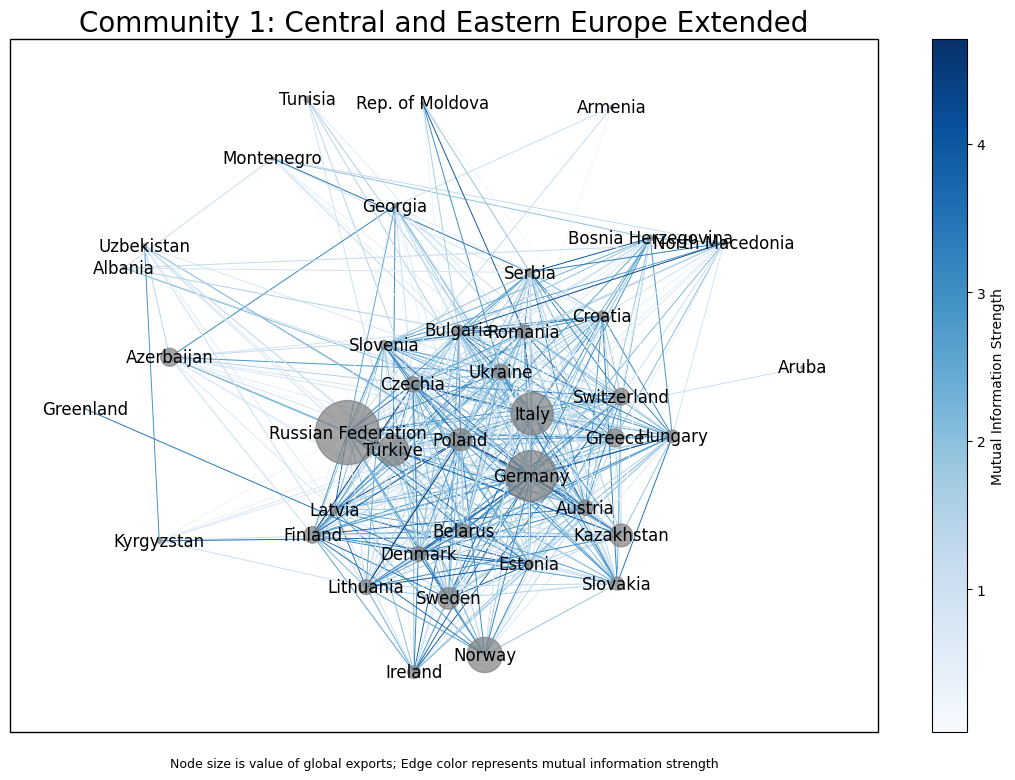

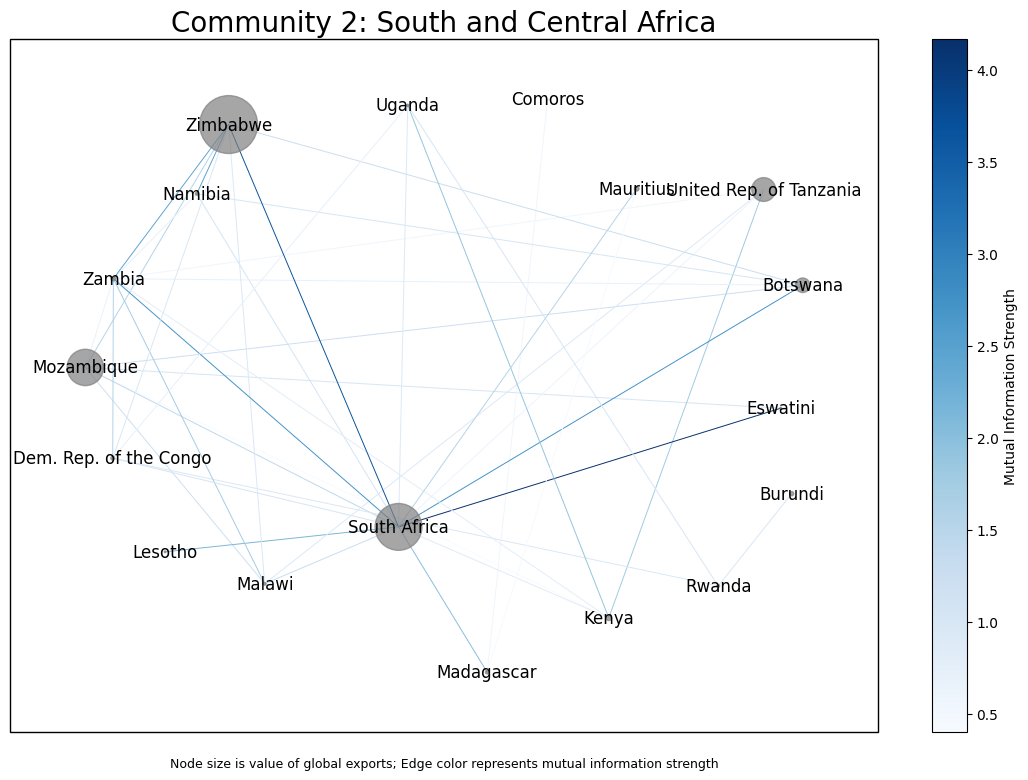

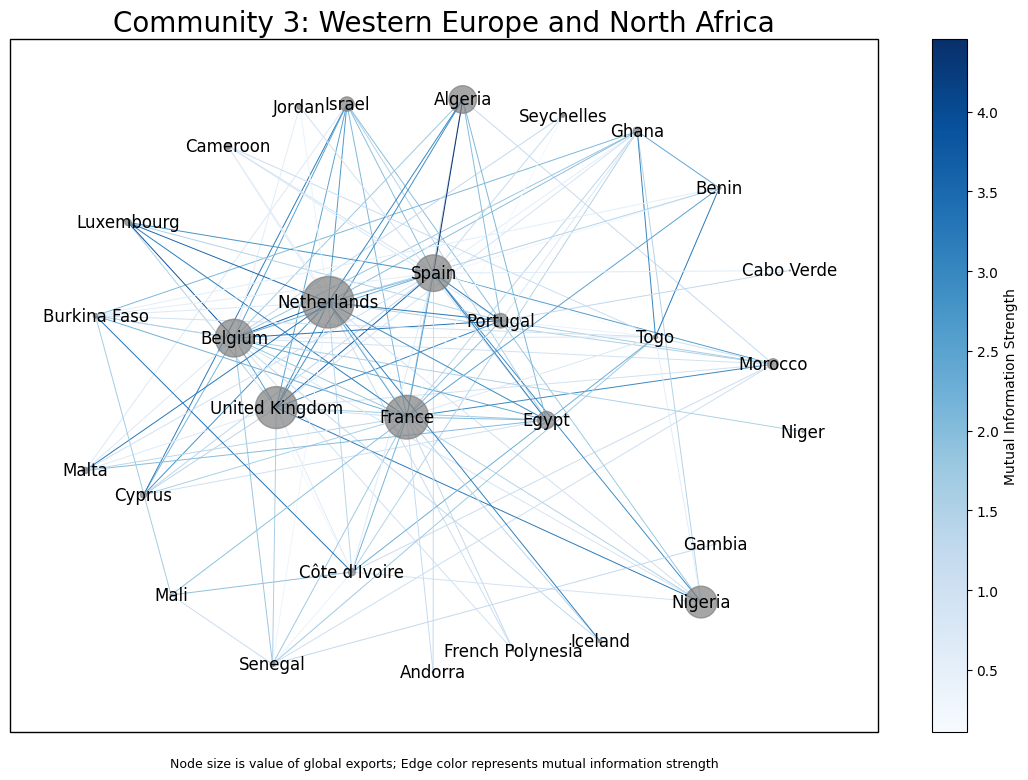

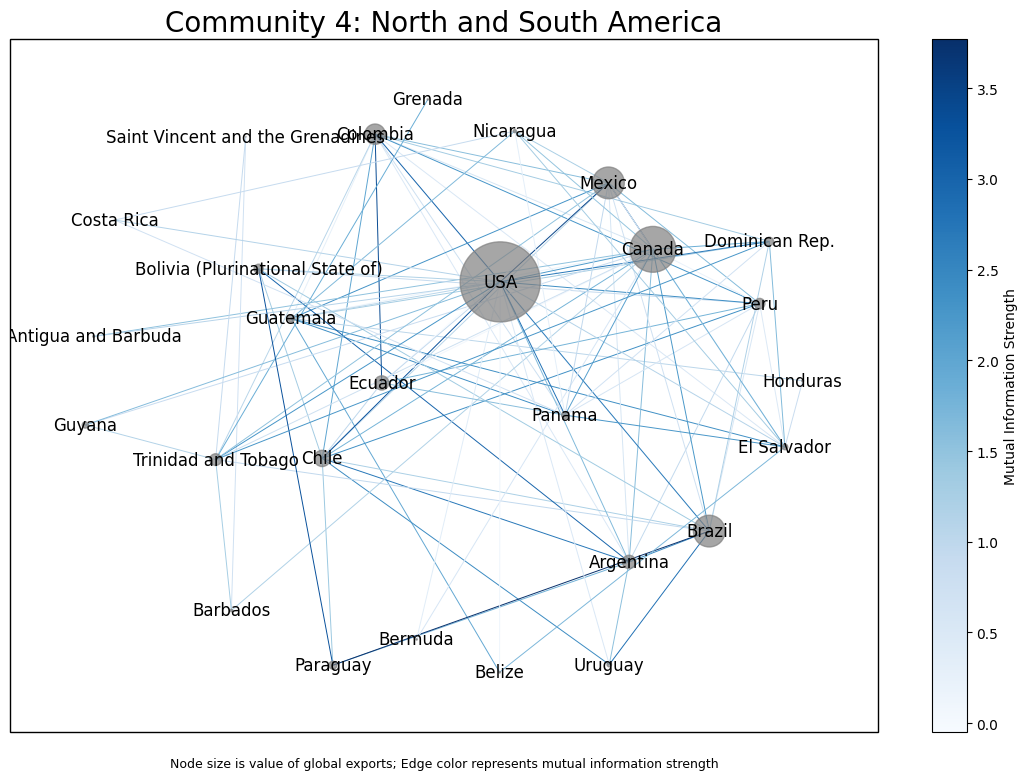

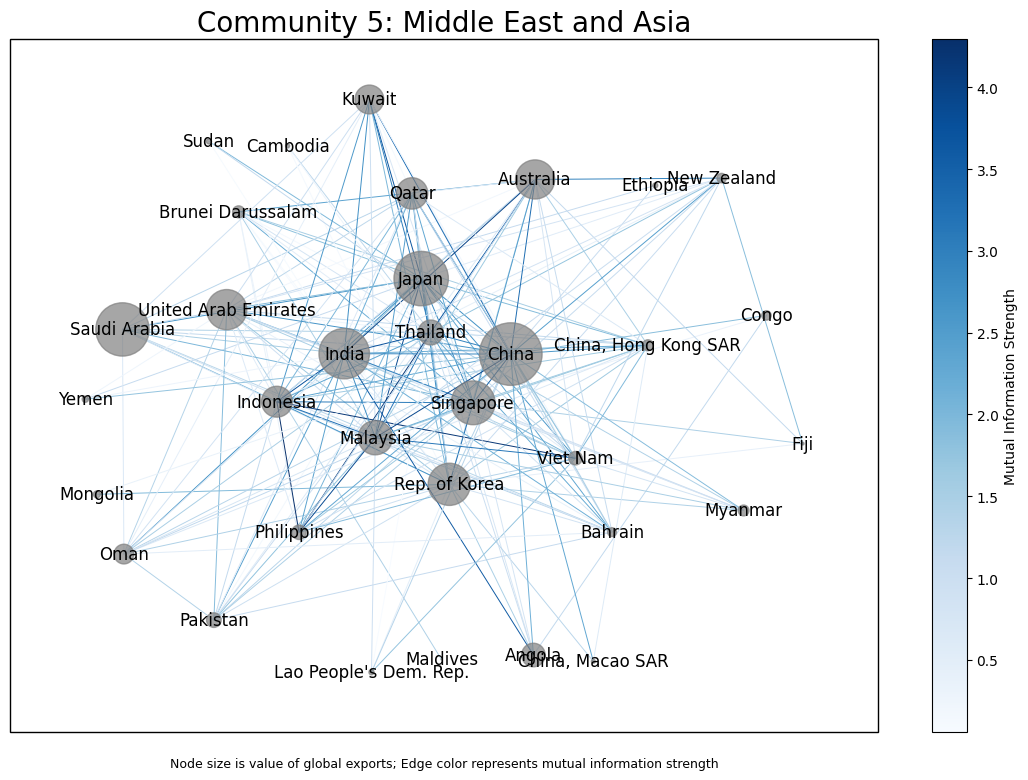

In [39]:
community_names = {
    0: "Central and Eastern Europe Extended",
    1: "South and Central Africa",
    2: "Western Europe and North Africa",
    3: "North and South America",
    4: "Middle East and Asia"
}

for community_id in set(partition.values()):
    subgraph_nodes = [node for node in partition if partition[node] == community_id]
    subgraph = G_mi.subgraph(subgraph_nodes)
    
    pos = nx.spring_layout(subgraph, k=15 / np.sqrt(len(subgraph.nodes())), iterations=50)
    
    title = f"Community {community_id + 1}: {community_names.get(community_id, 'Unknown')}"
    file_name = f"community_{community_id}.png"

    visualize_community_network(subgraph, avg_balance_df, pos, title, file_name, 15)


# Conclusion 

This study has systematically demonstrates the utility of Pairwise Mutual Information Weighted Graphs (PMIWG) in decoding interdependencies within the global mineral fuel trade networks. The empirical analysis and application of mutual information effectively captures the nuanced dynamics of bilateral trade relationships, revealing a distinct pattern of
economic interdependence influenced by unique trade policies, and bilateral agreements.

The research successfully validates the central hypothesis: mutual information can indeed elucidate the extent of interdependency in trade relationships. This conclusion is supported by significant mutual information values associated with country pairs that shared close geographical ties, trade agreements, or historically integrated supply chains. Additionally, the PMIWG’s community structure effectively maps the dense web of economic ties into distinct geopolitical and economic blocs, demonstrating that a pairwise approach could still
capture the complexities of international trade, albeit as a simplification of the multifaceted real-world system.

The community visualisations reveal varying interdependent relationships across economy pairs, elucidating the dynamics of intercountry integration that cannot be captured by other
forms of trade analysis. These discrepancies provided unique insights into the dependent structures within communities, often reflecting broader macroeconomic trends. Countries with Free Trade Agreements (FTAs) typically exhibited stronger mutual information ties compared to those without, and central trade hubs, like Netherlands and Belgium showcased a high number strong relationships. While the extent to which these interdependencies were represented could be debated, these observations establish a robust baseline for incorporating more complex multilateral dependencies in future research.

The analysis highlights the benefits of the non-parametric approach in accommodating the heterogeneity of trade data, enabling more accurate estimations of trade volume distributions. 

In conclusion, applying mutual information to study global trade dynamics in the hydrocarbon sectors not only validates the initial hypothesis, but also provides a robust framework for understanding the depth of interdependencies in a globally interconnected market.

# Limitations

However, there were limitations inherent in the methodology. The reliance on empirical distributions to calculate mutual information necessitated the discretization of continuous
trade volume variables into quantiles, which inevitably led to some loss of information. While the empirical findings of this research generally aligned with established economic principles,
there was a risk of subjective bias, where results were  interpreted in a way that supported the chosen methodology. 

Although the findings suggested that the pairwise mutual information framework captured meaningful economic relationships, no definitive method was employed to quantify the actual depth of these interdependencies or to rigorously test the framework against them. While the results indicate a capacity to capture significant economic connections, this does not necessarily confirm the underlying mechanisms of these interdependencies.

It is important to note that while mutual information effectively quantifies the reduction in uncertainty about one variable given knowledge of another, it does not establish causality. High mutual information between two countries indicates substantial economic connections but does not elucidate the specific dynamics of these relationships. Rather, it highlights the significance of these economic ties within the broader economic context. Moreover,
the research was limited to historically established bilateral trade relationships, overlooking more recent interdependencies that may have developed. It also did not capture the temporal
evolution of the network or the inherent directionality of causality. 

# Futher Research

This project has highlighted the highlighted mutual information as an effective methodology to assess non-linear relationships between economies. Further exploration leveraging other methodologies that effectively assess network dynamics, such as financial contagion and pairwise entropy transfer graphs, would enable analysis beyond the formation and validation of a respresentation of economic trade integration that has been explored here. 

Additionally, data with a higher level of specificity could enable a more purposeful exploration into specific economic shocks and industry phenomena. For example, exploring the dynamics of coal industry in Asia, the euro-russia natural gas and oil interdependencies before 2022, the impacts of US shale extraction becoming economically viable. These explorations would require a more sophisticated and purposeful approach network construction to effectively draw insights.  
